Neural networks that classify images are usually based on a process called [convolution](https://en.wikipedia.org/wiki/Convolution) (a kind of filtering), so they are called [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs or ConvNets). CNNs were initially developed for tasks like speech recognition, but in the late 90s Yann LeCun developed a net with high accuracy on the recognition of handwritten digits.

This network, or a similar one, is used regularly for reading the digits on handwritten checks and mail.

One of the more recent breakthroughs in image classification is on the [ImageNet recognition task](image-net.org/challenges/LSVRC/2012/browse-synsets). In 2012, Krizhevsky et al. got a 40% error rate ("top-1 error") for classification of objects from 1000 categories, using a CNN with more layers than previously. At the end of 2015, that error has dropped to 19% with research from [He et al.](http://arxiv.org/abs/1512.03385) at Microsoft, and 17% with work from [Szegedy et al.](http://arxiv.org/abs/1512.00567). You can see a picture of some different network architectures from 1998 to 2015 here: [Visualizing CNN architectures side by side with mxnet](http://josephpcohen.com/w/visualizing-cnn-architectures-side-by-side-with-mxnet/).

One of the best ways to understand what's going on inside a CNN is to [visualize the states at different layers](https://www.youtube.com/watch?v=AgkfIQ4IGaM). Andrej Karpathy has a great post describing [more things you can do with CNNs](http://cs231n.github.io/understanding-cnn/).

In this example we will use TensorFlow to label an image and compare similarity in two different ways.

First, we load TensorFlow and other libraries we will need.

In [1]:
import os.path
import numpy as np
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import matplotlib.pyplot as plt
from IPython.display import Image
from os.path import basename
from tqdm import tqdm
%matplotlib inline

Then we set up some variables to keep track of where the model files are, and load the model. This Inception-v3 network is almost 100MB and should have a 21% top-1 error, and 5% top-5 error.

In [2]:
model_dir = 'models/'
model_labels = os.path.join(model_dir, 'imagenet_comp_graph_label_strings.txt')
model_file = os.path.join(model_dir, 'tensorflow_inception_graph.pb')
def create_graph(model_file):
  with gfile.FastGFile(model_file, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
%time create_graph(model_file)

CPU times: user 1.3 s, sys: 132 ms, total: 1.43 s
Wall time: 1.46 s


Now we define a function that can load and process our images, with one flag that tells it whether to extract output from the final output of the network, or just before the final output. We'll get back to that in a moment.

In [3]:
def run_inference_on_image(image):
  image_data = gfile.FastGFile(image, 'rb').read()
  with tf.Session() as sess:
    pool, softmax = sess.run(('pool_3:0', 'softmax:0'), {'DecodeJpeg/contents:0': image_data})
    return softmax.reshape(-1), pool.reshape(-1)

Now we get a list of all the files to process.

In [8]:
import os
import fnmatch

def list_all_files(directory, extensions=None):
    for root, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            base, ext = os.path.splitext(filename)
            joined = os.path.join(root, filename)
            if extensions is None or ext.lower() in extensions:
                yield joined
                
files = list(list_all_files('../Teenie_Harris_JPG640/', ['.jpeg']))
# files = files[47622:] # skip a bunch of them
print len(files)

59278


Running this code on an image looks like this:

In [6]:
%time predictions, features = run_inference_on_image(files[0])

CPU times: user 2.19 s, sys: 483 ms, total: 2.67 s
Wall time: 1.5 s


In [7]:
with open('predictions.csv', 'a') as pout, open('features.csv', 'a') as fout, open('filenames.csv', 'a') as fnout:
    for fn in tqdm(files):
        predictions, features = run_inference_on_image(fn)
        
        pout.write(','.join(map(str,predictions))+'\n')
        pout.flush()
        
        fout.write(','.join(map(str,features))+'\n')
        fout.flush()
        
        fnout.write(basename(fn)+'\n')
        fnout.flush()

100%|██████████| 11656/11656 [4:22:14<00:00,  1.36s/it]


And we can see the classification vector it returns has 1008 elements (not sure why it's 1008 instead of 1000).

If we plot the vector we can see one peak and a few smaller peaks.

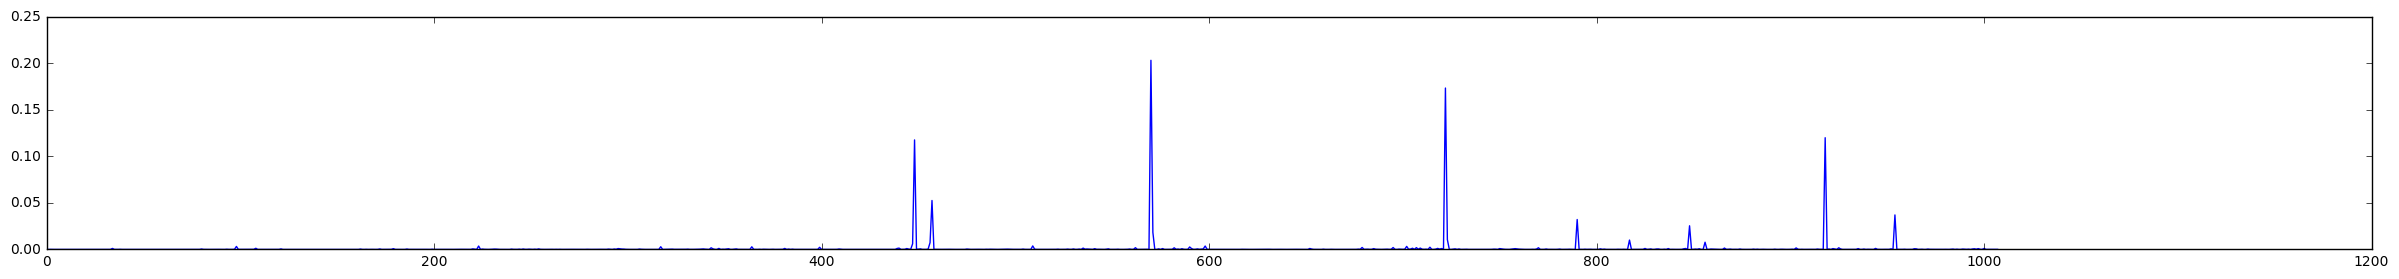

In [71]:
plt.figure(figsize=[30, 3])
plt.plot(predictions)
plt.show()

To figure out what the name of this category is, we need to load the category names (also called synset names).

In [72]:
labels = []
with open(model_labels) as f:
    for label in f.readlines():
        labels.append(label.strip())
len(labels)

1001

Then we can use `argmax()` to find the index of that peak, and look up the word at that index.

In [73]:
labels[predictions.argmax()]

'reel'

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]